In [201]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np
import scipy.stats as st
from scipy.stats import linregress

mouse_metadata = Path("data/Mouse_metadata.csv")
study_results = Path("data/Study_results.csv")

mouse_metadata_df = pd.read_csv(mouse_metadata)
study_results_df = pd.read_csv(study_results)

# display(mouse_metadata_df)
# display(study_results_df)

# Mouse_metadata contains identifying characteristics of each mouse as well as its assigned drug.
# Study_results is time-variant tumor data over 46 study days

study_complete_df = pd.merge(study_results_df, mouse_metadata_df, on="Mouse ID")
display(study_complete_df.head().style.set_caption("All Mouse Data"))

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,0,45.000000,0,Capomulin,Female,9,22
1,f932,0,45.000000,0,Ketapril,Male,15,29
2,g107,0,45.000000,0,Ketapril,Female,2,29
3,a457,0,45.000000,0,Ketapril,Female,11,30
4,c819,0,45.000000,0,Ketapril,Male,21,25


In [202]:
# Prepare the data: display then remove duplicate mice-timepoint data, establish de-duplicated DataFrame, display updated total mice

# Find the number of mice
print(f"Number of unique mice: " + str(len(mouse_metadata_df["Mouse ID"].value_counts())))

# Locate mice with duplicate timepoint data
study_complete_df["Is Duplicated"] = study_complete_df.duplicated(subset=["Mouse ID", "Timepoint"], keep=False)
duplicates_df = study_complete_df.loc[study_complete_df["Is Duplicated"] == True, :]
duplicate_mice = pd.Series(duplicates_df["Mouse ID"].unique())
for mouse in duplicate_mice:
    print(f"Mice with duplicate timepoint data: " + str(mouse))

# Display all data associated with above mice
duplicate_mice_df = pd.DataFrame()
for mouse in duplicate_mice:
    duplicate_mouse_df = study_complete_df.loc[study_complete_df["Mouse ID"] == mouse, :]
    duplicate_mice_df = pd.concat([duplicate_mice_df, duplicate_mouse_df], axis=0)
display(duplicate_mouse_df.style.set_caption("Data associated with mice with duplicate timepoint data"))

# Remove above data to create a cleaned DataFrame
cleaned_df = study_complete_df.loc[study_complete_df["Mouse ID"] != "g989", :].drop("Is Duplicated", axis=1).reset_index(drop=True)
display(cleaned_df.head().style.set_caption("Cleaned data"))

Number of unique mice: 249
Mice with duplicate timepoint data: g989


,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g),Is Duplicated
107,g989,0,45.000000,0,Propriva,Female,21,26,True
137,g989,0,45.000000,0,Propriva,Female,21,26,True
329,g989,5,48.786801,0,Propriva,Female,21,26,True
360,g989,5,47.570392,0,Propriva,Female,21,26,True
620,g989,10,51.745156,0,Propriva,Female,21,26,True
681,g989,10,49.880528,0,Propriva,Female,21,26,True
815,g989,15,51.325852,1,Propriva,Female,21,26,True
869,g989,15,53.442020,0,Propriva,Female,21,26,True
950,g989,20,55.326122,1,Propriva,Female,21,26,True
1111,g989,20,54.657650,1,Propriva,Female,21,26,True


,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,0,45.000000,0,Capomulin,Female,9,22
1,f932,0,45.000000,0,Ketapril,Male,15,29
2,g107,0,45.000000,0,Ketapril,Female,2,29
3,a457,0,45.000000,0,Ketapril,Female,11,30
4,c819,0,45.000000,0,Ketapril,Male,21,25


In [203]:
# Generate summary statistics

# Group the cleaned data by drug
grouped_df = cleaned_df.groupby(["Drug Regimen"])
# display(grouped_df.first())

# Record the summary statistics for each drug
mean = grouped_df["Tumor Volume (mm3)"].mean()
median = grouped_df["Tumor Volume (mm3)"].median()
variance = grouped_df["Tumor Volume (mm3)"].var()
std_dev = grouped_df["Tumor Volume (mm3)"].std()
sem = grouped_df["Tumor Volume (mm3)"].sem()

summary_statistics_df = pd.DataFrame({
    "Mean": mean,
    "Median": median,
    "Variance": variance,
    "Standard Deviation": std_dev,
    "Standard Error of the Mean": sem
})

summary_statistics_df.style.set_caption("Summary Statistics of Tumor Volume")


,Mean,Median,Variance,Standard Deviation,Standard Error of the Mean
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


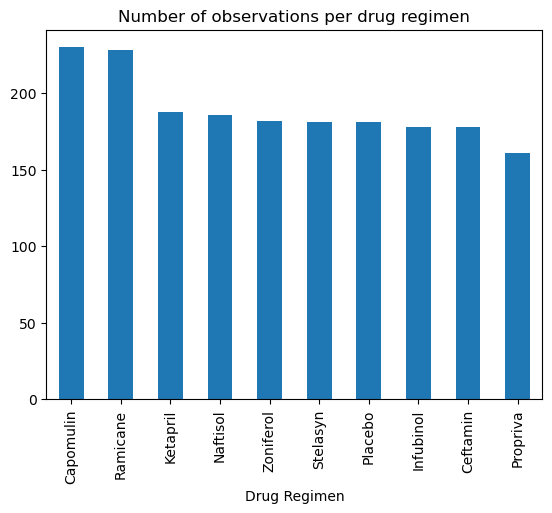

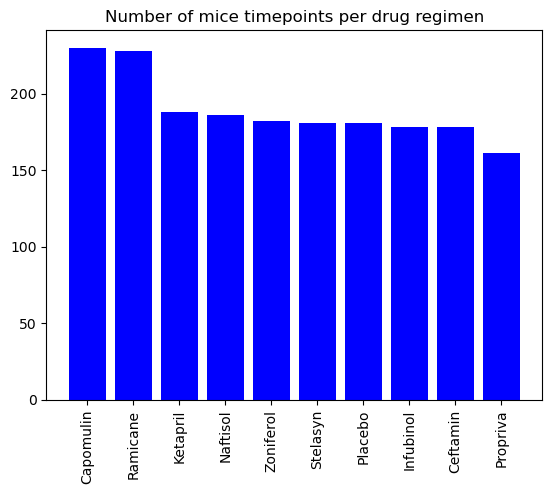

In [204]:
# Create bar charts

total_rows_df = study_complete_df["Drug Regimen"].value_counts()

# Create bar chart using DataFrame.plot() method
total_rows_df.plot(kind="bar")
plt.title("Number of observations per drug regimen")
plt.show()

# Create bar chart using matplotlib plt.plot() method
x_axis = np.arange(0,10)
plt.bar(x_axis, total_rows_df, color="b")
plt.title("Number of mice timepoints per drug regimen")

drug_regimens = pd.Series(total_rows_df.index)
tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, drug_regimens, rotation="vertical")
plt.show();

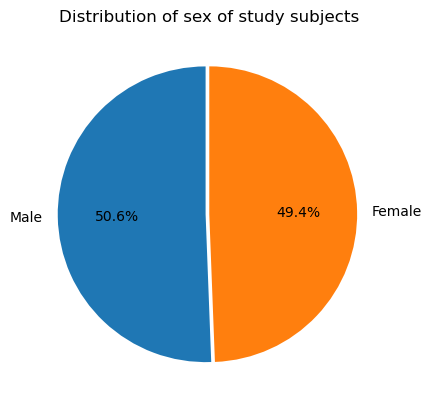

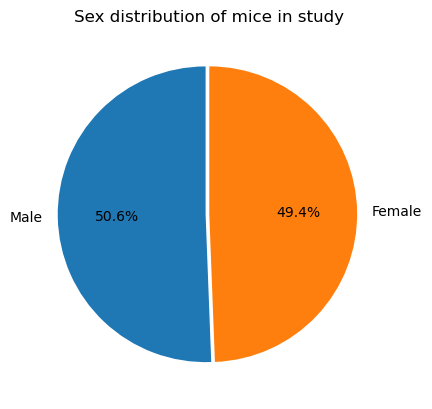

In [205]:
# Create pie charts

sex_df = study_complete_df["Sex"].value_counts()

explode = (0.025, 0)

sex_df.plot(kind="pie", startangle=90, autopct="%1.1f%%",explode=explode, title="Distribution of sex of study subjects", ylabel='')
plt.show()

plt.pie(sex_df, labels=sex_df.index, startangle=90, autopct="%1.1f%%", explode=explode)
plt.title("Sex distribution of mice in study")
plt.show()


,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
Mouse ID,,,,,,,
a203,45,67.973419,2,Infubinol,Female,20,23
a251,45,65.525743,1,Infubinol,Female,21,25
a262,45,70.717621,4,Placebo,Female,17,29
a275,45,62.999356,3,Ceftamin,Female,20,28
a366,30,63.440686,1,Stelasyn,Female,16,29


,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g),Final Tumor Volume
0,b128,0,45.000000,0,Capomulin,Female,9,22,38.982878
1,f932,0,45.000000,0,Ketapril,Male,15,29,45.000000
2,g107,0,45.000000,0,Ketapril,Female,2,29,71.905117
3,a457,0,45.000000,0,Ketapril,Female,11,30,49.783419
4,c819,0,45.000000,0,Ketapril,Male,21,25,62.175705


Outlier final tumor volumes for Capomulin: []
Outlier final tumor volumes for Ramicane: []
Outlier final tumor volumes for Infubinol: [36.3213458]
Outlier final tumor volumes for Ceftamin: []


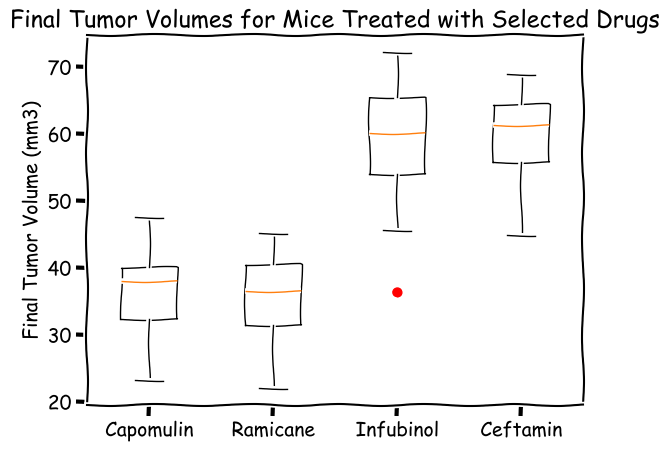

In [206]:
# Calculate quartiles, find outliers, and create a box plot for final tumor volume of selected drugs

# Group by mouse and display the last timepoint for each mouse
grouped_df = cleaned_df.groupby(["Mouse ID"])
final_timepoint_df = grouped_df.last()
display(final_timepoint_df.head().style.set_caption("Final Timepoint of Each Study Mouse"))
# cleaned_df.loc[cleaned_df["Mouse ID"] == "z435", :] Checks if groupby Mouse ID works correctly

# Create new DataFrame that adds final timepoint's tumor volume to each row
final_timepoint_volume_df = final_timepoint_df[["Tumor Volume (mm3)"]].rename(columns={"Tumor Volume (mm3)": "Final Tumor Volume"})
study_final_df = pd.merge(cleaned_df, final_timepoint_volume_df, on="Mouse ID")
display(study_final_df.head().style.set_caption("Study Data with Final Tumor Volume Appended"))

# Select drugs of interest
drugs = ["Capomulin", "Ramicane", "Infubinol", "Ceftamin"]

# Create list to hold final tumor volume data to prepare for plotting
final_tumor_volumes = []

# Loop over selected drugs, locate final tumor volume data, and add to list of lists
for drug in drugs:
    tumor_volume = study_final_df.loc[study_final_df["Drug Regimen"] == drug]["Final Tumor Volume"].unique().tolist()
    final_tumor_volumes.append(tumor_volume)

# Create DataFrame: decided not to do this since different drugs may have different count of associated tumor volumes

# Calculate quartiles, IQRs, and identify outliers for each selected drug dataset

# For each list of final tumor volumes, calculate the quartiles and store as a list of Series
quartiles = []
for volume in final_tumor_volumes:
    volume_Series = pd.Series(volume) # Convert to Series because .quantile() can only be called on Series and DataFrames
    quartile = volume_Series.quantile([0.25, 0.5, 0.75])
    quartiles.append(quartile)

# For each Series of quartiles, compare the associated drug regimen's final tumor volumes to the lower and upper bounds
outliers = []
for i, quartile in enumerate(quartiles, start=0): # Use enumerate in Python instead of i++
    iqr = 1.5 * (quartile.iloc[2] - quartile.iloc[0])
    lower = quartile.iloc[0] - iqr
    upper = quartile.iloc[2] + iqr
    for volume in final_tumor_volumes[i]:
        if (volume < lower) | (volume > upper):
            outliers.append(volume)
    print(f"Outlier final tumor volumes for " + str(drugs[i]) + ": " + str(outliers))
    outliers = []

# Create boxplots
with plt.xkcd():
    plt.rcParams["font.family"] = "Comic Sans MS"
    fig, ax = plt.subplots()
    ax.set_title("Final Tumor Volumes for Mice Treated with Selected Drugs")
    ax.set_ylabel("Final Tumor Volume (mm3)")
    ax.boxplot(final_tumor_volumes, sym="ro")
    ax.set_xticks(range(1, len(drugs)+1)) # Boxplot xticks are 1-indexed
    ax.set_xticklabels(drugs)
    plt.show()

Mouse b128 was treated with Capomulin. Below is displayed its tumor volume over time.


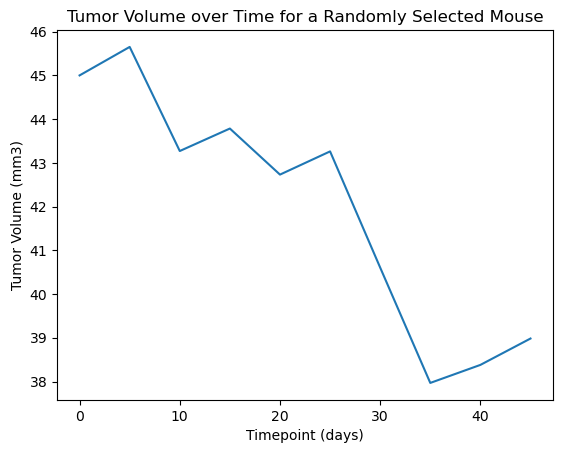

In [207]:
# Create a line plot

# Select a single mouse that was treated with a selected drug
drug = "Capomulin" # Define the selected drug
mice = cleaned_df.loc[cleaned_df["Drug Regimen"] == drug, "Mouse ID"].unique() # Get all mice treated by the selected drug
mouse = np.random.choice(mice) # Choose a mouse randomly
print(f"Mouse " + str(mouse) + " was treated with " + str(drug) + ". Below is displayed its tumor volume over time.")

# Create a line plot of tumor volume versus timepoint
mouse_data_df = cleaned_df.loc[cleaned_df["Mouse ID"] == mouse, ["Timepoint", "Tumor Volume (mm3)"]] # Select data for the plot's x and y
# print(mouse_data_df)

plt.plot(mouse_data_df["Timepoint"], mouse_data_df["Tumor Volume (mm3)"])
plt.title("Tumor Volume over Time for a Randomly Selected Mouse")
plt.xlabel("Timepoint (days)")
plt.ylabel("Tumor Volume (mm3)")
plt.show()

,Mouse ID,Weight (g),Tumor Volume (mm3)
23,x401,15,36.182040
24,y793,17,38.506829
19,u364,17,39.887495
2,f966,17,36.505973
18,t565,17,39.328725
16,s185,17,34.559143
14,r554,17,36.509212
11,m601,17,34.847470
10,l897,19,42.507261
12,m957,19,39.049816


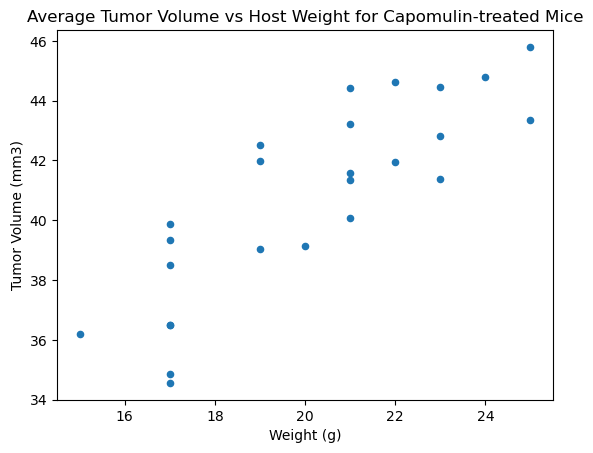

In [208]:
# Create a scattor plot of mouse weight vs. average tumor volume for the selected drug

# Isolate data of interest and filter by selected drug
mouse_data_df = cleaned_df.loc[cleaned_df["Drug Regimen"] == drug, :][["Mouse ID", "Timepoint", "Tumor Volume (mm3)", "Weight (g)"]]
# display(mouse_data_df)

# Get average tumor volume by weight for each mouse
average_tumor_volume_df = mouse_data_df.groupby(["Mouse ID", "Weight (g)"])["Tumor Volume (mm3)"].mean().reset_index().sort_values("Weight (g)")
display(average_tumor_volume_df)

# Plot scatter
average_tumor_volume_df.plot(kind="scatter", x="Weight (g)", y="Tumor Volume (mm3)", grid=False, title=f"Average Tumor Volume vs Host Weight for {drug}-treated Mice")
plt.show()

The correlation between average tumor volume and weight is 0.84.
The liner regression model is y = 0.95x + 21.55


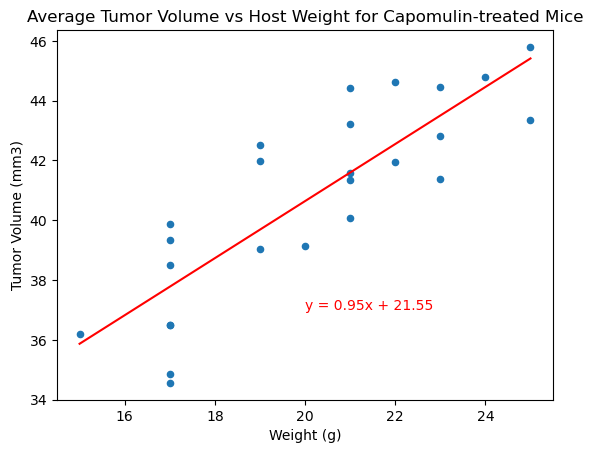

In [209]:
# Calculate correlation coefficient

correlation = st.pearsonr(average_tumor_volume_df["Weight (g)"], average_tumor_volume_df["Tumor Volume (mm3)"])
print(f"The correlation between average tumor volume and weight is " + str(round(correlation[0], 2)) + ".")

# Calculate the linear regression model
(slope, intercept, rvalue, pvalue, stderr) = linregress(average_tumor_volume_df["Weight (g)"], average_tumor_volume_df["Tumor Volume (mm3)"])
print(f"The liner regression model is y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2)))
line_equation = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))

# Prepare the line plot and overlay on previous scatter plot
x_values = average_tumor_volume_df["Weight (g)"]
y_values = x_values * slope + intercept

average_tumor_volume_df.plot(kind="scatter", x="Weight (g)", y="Tumor Volume (mm3)", title=f"Average Tumor Volume vs Host Weight for {drug}-treated Mice")
plt.plot(x_values, y_values, color="red")
plt.annotate(line_equation, (20, 37), color="red")
plt.show()